# Deep learning with scPortrait

scPortrait was built to facilitate the generation of single-cell representations from raw microscopy images. To do this, scPortrait integrates with existing Deep learning frameworks. In this tutorial we will show you how to create a dataloader containg scPortrait's single-cell images and augment a dataset with additional transforms. The generated dataset can then be used in downstream applications like model inference or training.

In [2]:
from scportrait.tools.ml.datasets import H5ScSingleCellDataset
from scportrait.tools.ml.transforms import RandomRotation, GaussianBlur, GaussianNoise
from scportrait.data._datasets import autophagosome_h5sc
import scportrait

import torch
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Creating a Dataloader

Using the `HDF5SingleCellDataset` class provided with scPortrait you can easily create a PyTorch DataLoader with your single-cell images. 

By default the generated PyTorch Dataloader returns a tensor containing the single-cell images, the assigned labels and the unique `scportrait_cell_id` allowing you to map inference results back to your original sample.

Lets do an example where we load two single-cell image datasets of U2OS cells with a high and low of autophagosomes from the original [SPARCS manuscript](https://doi.org/10.1101/2023.06.01.542416). We will assign the unstimulated cells the label 0.

In [3]:
dataset_paths = autophagosome_h5sc()
labels = [0, 1]
dataset = H5ScSingleCellDataset(dataset_paths,
                                labels,
                                return_id=True,
                                select_channel=None)

Downloading...: 9.88MB [00:01, 5.98MB/s]

Total single cell records: 60


By printing the detailled stats of our dataset we can see that we have 30 cells belonging to class 0 (stimulated) und 30 cells belonging to the class 1 (unstimulated).

In [4]:
dataset.stats(detailed=True)

Total single cell records: 60
single cell records with label 0 : 30
single cell records with label 1 : 30


We can now pass the created dataset to the PyTorch DataLoader class, allowing us to easily access our single-cell images.

In [5]:
dataloader = DataLoader(dataset)

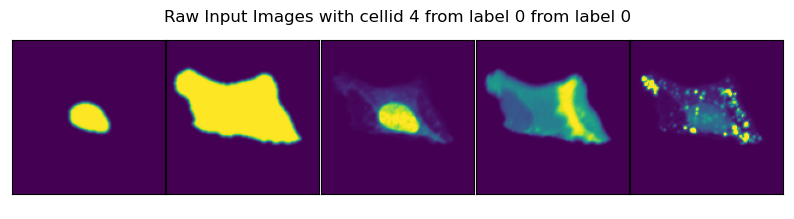

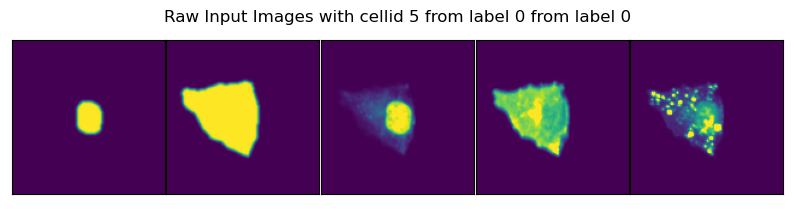

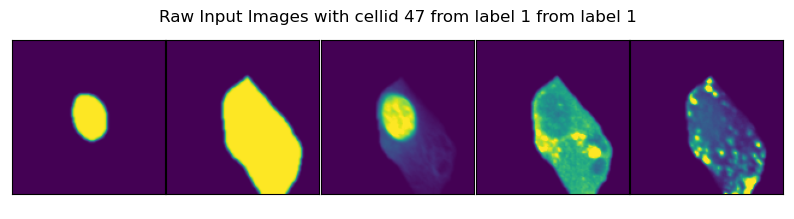

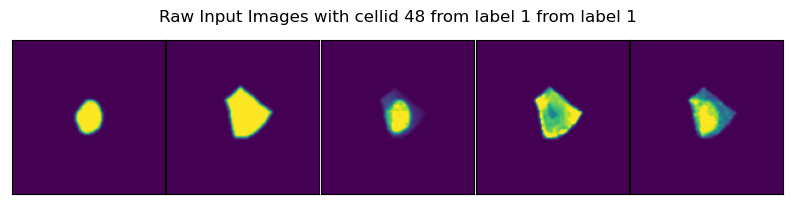

In [6]:
data_iter = iter(dataloader)

for ix in range(len(dataset)):
    data = next(data_iter)
    image, label, cell_id = data

    if ix < 2:
        fig, axs = plt.subplots(1, 1, figsize=(2*image.shape[1], 2.4))
        scportrait.pl.h5sc._plot_image_grid(
            axs,
            image.reshape(5, image.shape[2], image.shape[3]),
            nrows = 1,
            ncols = image.shape[1],
            axs_title=f"Raw Input Images with cellid {int(cell_id)} from label {int(label)} from label {int(label)}"
            )

    if ix > 57:
        fig, axs = plt.subplots(1, 1, figsize=(2*image.shape[1], 2.4))
        scportrait.pl.h5sc._plot_image_grid(
            axs,
            image.reshape(5, image.shape[2], image.shape[3]),
            nrows = 1,
            ncols = image.shape[1],
            axs_title=f"Raw Input Images with cellid {int(cell_id)} from label {int(label)} from label {int(label)}"
            )

By specifying `select_channel` you can also only return a subset of channels or even single channels. 

Since we use chunked HDF5 access in our created Dataset, selecting channels directly during dataset creation is more efficient than e.g. using a downstream transform because we only load the data you actually want to work with from disk.

Total single cell records: 60


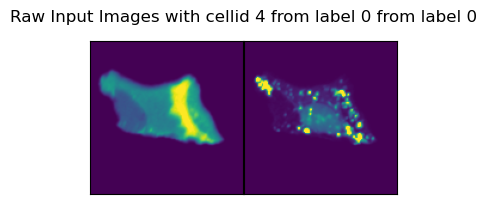

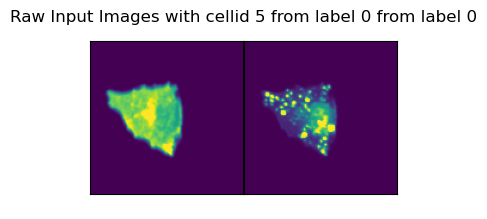

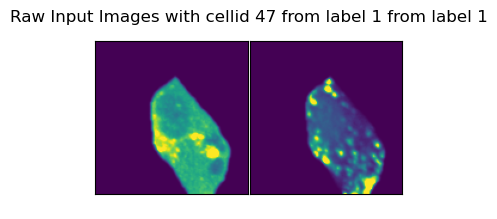

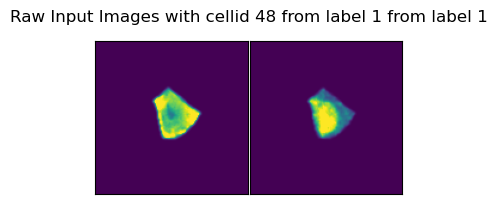

In [7]:
dataset = H5ScSingleCellDataset(dataset_paths,
                                labels,
                                return_id=True,
                                select_channel=[3, 4])

dataloader = DataLoader(dataset)

data_iter = iter(dataloader)

for ix in range(len(dataset)):
    data = next(data_iter)
    image, label, cell_id = data

    if ix < 2:
        fig, axs = plt.subplots(1, 1, figsize=(2*image.shape[1], 2.4))
        scportrait.pl.h5sc._plot_image_grid(
            axs,
            image.reshape(image.shape[1], image.shape[2], image.shape[3]),
            nrows = 1,
            ncols = image.shape[1],
            axs_title=f"Raw Input Images with cellid {int(cell_id)} from label {int(label)} from label {int(label)}"
            )

    if ix > 57:
        fig, axs = plt.subplots(1, 1, figsize=(2*image.shape[1], 2.4))
        scportrait.pl.h5sc._plot_image_grid(
            axs,
            image.reshape(image.shape[1], image.shape[2], image.shape[3]),
            nrows = 1,
            ncols = image.shape[1],
            axs_title=f"Raw Input Images with cellid {int(cell_id)} from label {int(label)} from label {int(label)}"
            )


## Augmenting Images

As with all PyTorch Datasets you can augment your datasets through the use of transforms. Below we will demonstrate the effect of some transforms by applying them to a single image of a cell.

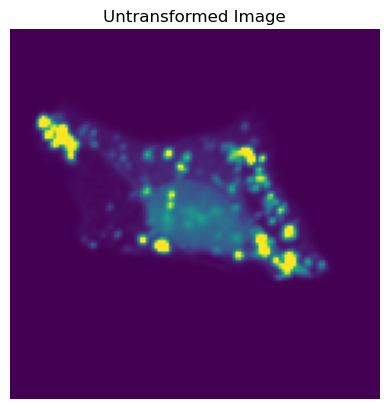

In [8]:
channel_selection = 1

data_iter = iter(dataloader)
for ix in range(len(dataset)):
    data = next(data_iter)
    image, label, cell_id = data
    if ix == 0: break

orig_image = image[0][channel_selection].detach().numpy().copy()
orig_tensor = image.detach().numpy().copy() # we must preserve a copy here as the transform will modify the original tensor

plt.imshow(orig_image)
plt.title("Untransformed Image");
plt.axis('off');

We will compare 20 different runs of the same transformation on the same input image.

In [9]:
reps = 20
rows = np.sqrt(reps).astype(int)
cols = np.ceil(reps/rows).astype(int)

### Random Rotation

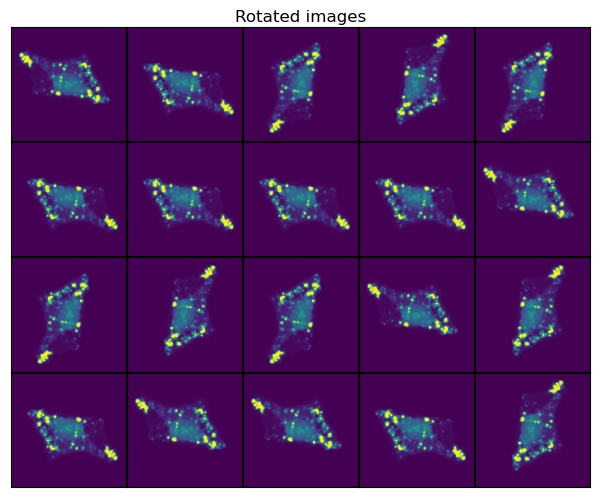

In [10]:
t_rotation = RandomRotation()

transformed = []
for i in range(reps):
    t = t_rotation(torch.tensor(orig_tensor))
    transformed.append(t[0, channel_selection, :, :].numpy())

fig, axs  = plt.subplots(1, 1, figsize=(1.5*cols, 1.5 * rows))
scportrait.pl.h5sc._plot_image_grid(axs, transformed, rows, cols, axs_title="Rotated images")


### Gaussian Blur

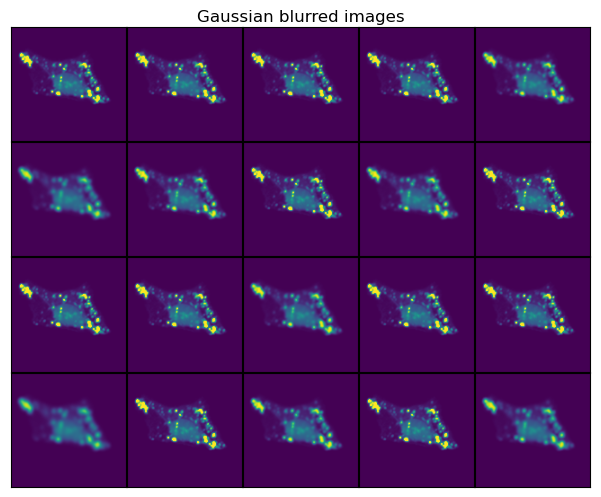

In [11]:
t_blur = GaussianBlur()

transformed = []
for i in range(reps):
    t = t_blur(torch.tensor(orig_tensor))
    transformed.append(t[0, channel_selection, :, :].numpy())

fig, axs  = plt.subplots(1, 1, figsize=(1.5*cols, 1.5 * rows))
scportrait.pl.h5sc._plot_image_grid(axs, transformed, rows, cols, axs_title="Gaussian blurred images")

### Gaussian Noise

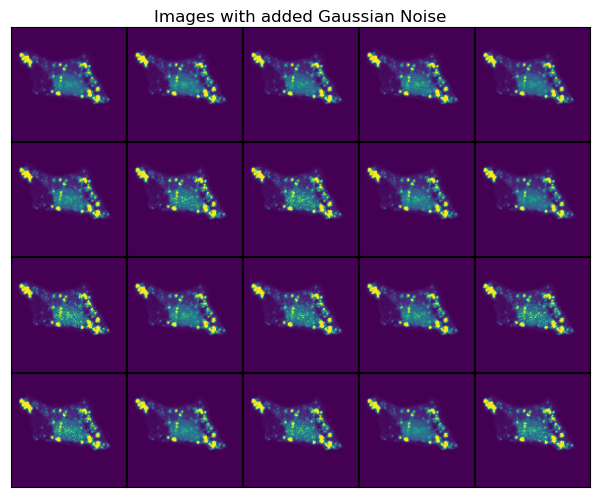

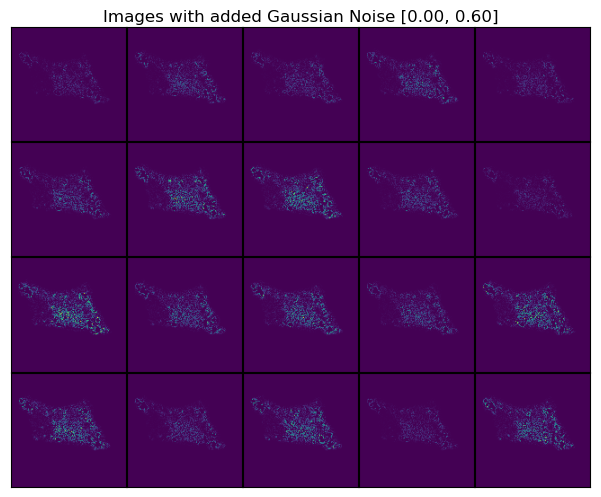

In [12]:
t_gaussiannoise = GaussianNoise(sigma = (0.01, 0.5))

transformed = []
for i in range(reps):
    t = t_gaussiannoise(torch.tensor(orig_tensor))
    transformed.append(t[0, channel_selection, :, :].numpy())

# compute the added noise so we can display it seperately making the effect easier to see
added_noise = np.array([x - orig_image for x in transformed])

fig, axs  = plt.subplots(1, 1, figsize=(1.5*cols, 1.5 * rows))
scportrait.pl.h5sc._plot_image_grid(axs, transformed, rows, cols, axs_title="Images with added Gaussian Noise")

fig, axs  = plt.subplots(1, 1, figsize=(1.5*cols, 1.5 * rows))
scportrait.pl.h5sc._plot_image_grid(axs,
                                    added_noise,
                                    rows,
                                    cols,
                                    vmin = added_noise.min(),
                                    vmax = added_noise.max(),
                                    axs_title=f"Images with added Gaussian Noise [{added_noise.min():.2f}, {added_noise.max():.2f}]")



### Using transforms during dataset creation

To make our lives easier we can apply the transforms directly during dataset creation. Now, whenever the single-cell images are retrieved from disk, the transforms will automatically be applied.

Let's simulate a small training run with `10` epochs and inspect how the same single-cell image would look in each epoch.

Total single cell records: 60


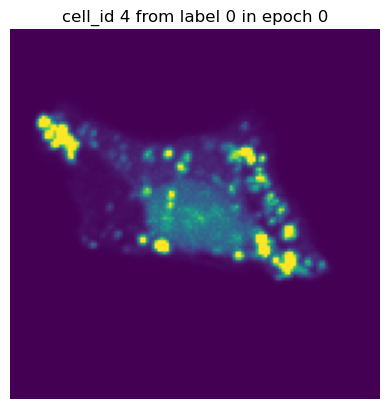

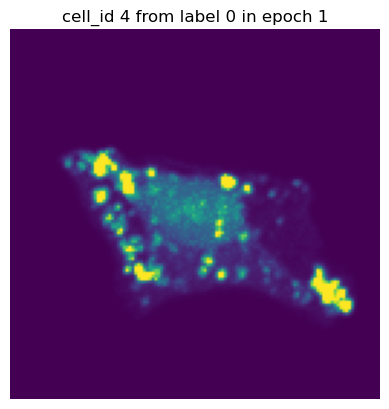

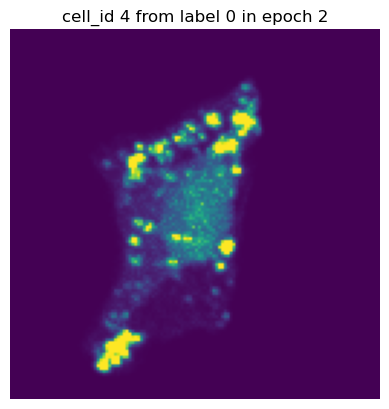

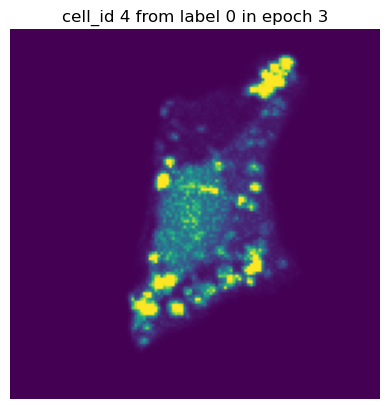

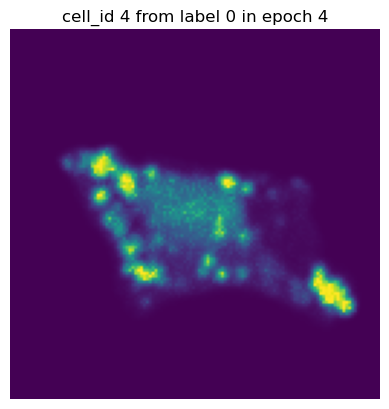

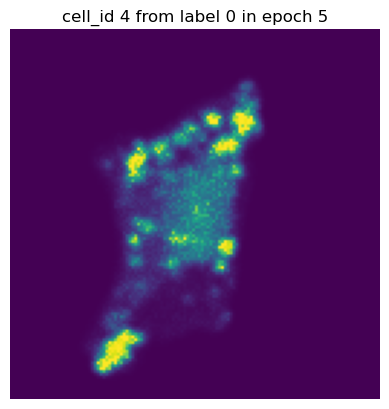

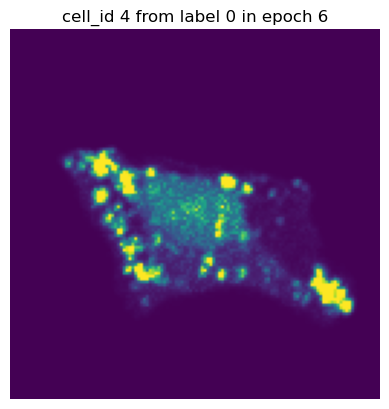

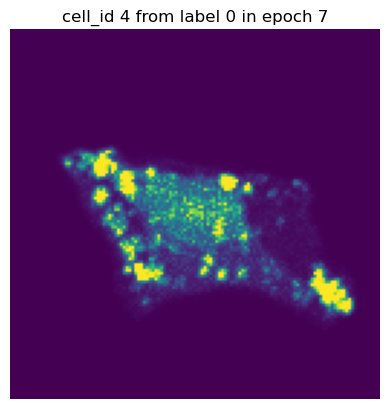

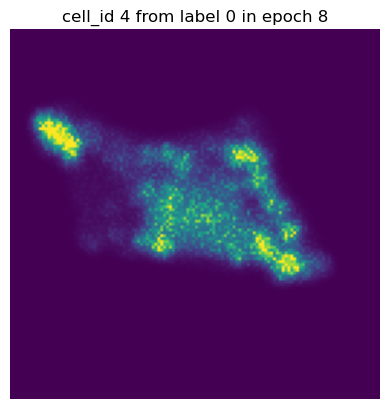

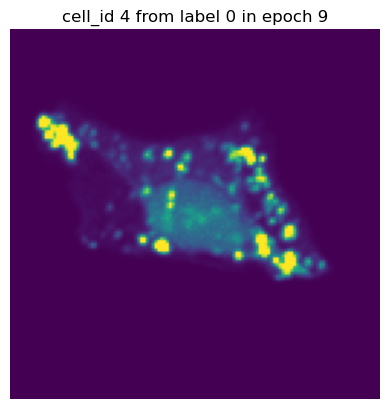

In [13]:
transform = Compose([GaussianBlur(),
                     GaussianNoise(sigma = (0.01, 0.5)),
                     RandomRotation()])

dataset = H5ScSingleCellDataset(dataset_paths,
                                labels,
                                transform=transform,
                                return_id=True,
                                select_channel=[4]) # this time we will only get the single-channel we are interested in

dataloader = DataLoader(dataset,  batch_size=10, shuffle=False) #we turn of shuffling so that the same cell will also be in the same batch

n_epochs = 10
for n in range(n_epochs):
    data_iter = iter(dataloader)
    for i in range(len(dataloader)):
        images, label, cell_ids = next(data_iter)
        # visualize the first cell of the first batch
        if i == 0:
            plt.figure()
            plt.imshow(images[0][0].detach().numpy())
            plt.axis('off')
            plt.title(f"cell_id {cell_ids[0]} from label {label[0]} in epoch {n}")
            plt.show()


In each of our batches our input cell looks quite different due to the applied transforms. We have successfully augmented our input dataset to introduce more variance and hopefully make our trained model more robust.

## Using scPortrait single-cell image datasets with existing DL libraries

Since you can easily generate a standard PyTorch Dataloader directly from scPortrait's `.h5sc` single-cell image files you can integrate scPortrait with existing deep learning frameworks, either to train your own models or to utilize existing models for inference on your datasets.

Here are a few recommended tutorials to get started: 

- [`pyTorch`](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [`pyTorch Lightning`](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)

You can even integrate your datasets with existing models from repos like [`transformers`](https://huggingface.co/docs/transformers/en/index).